# <span style="color:orange">I. Import Required Libraries</span>


In [1]:
# some required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from collections import Counter
import contractions
from nrclex import NRCLex
from textblob import TextBlob
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import joblib

# Spacy
import spacy
# Load the pre-trained spaCy model
nlp = spacy.load('en_core_web_sm')

# Word Cloud
from wordcloud import WordCloud

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# randomundersampler
from imblearn.under_sampling import RandomUnderSampler

# <span style="color:orange">II. Load Dataset</span>

In [2]:
# Read positive reviews
with open('Datasets/positive-reviews.txt', 'r', encoding='utf-8') as f:
    positive_reviews = f.readlines()

# Read negative reviews
with open('Datasets/negative-reviews.txt', 'r', encoding='utf-8') as f:
    negative_reviews = f.readlines()

In [3]:
positive_reviews[:10]

['Size, Size, ans Size.\n',
 'Excellent quality, speedy printing, low cost\n',
 'Cheap, good quality, small size\n',
 'Attractive design, satisfying features, the backlight!\n',
 'Pretty much has every feature you could possibly need, great look\n',
 'Ease of use, small size and reliability\n',
 'cheap,good print quality\n',
 'takes clear shots\n',
 'Small, Light, Stylish, backlight\n',
 'Absolutely Outstanding Photo Printing Results.  Easy to Use.\n']

In [4]:
negative_reviews[:10]

['Image quality not as good as some other brands, cheap feel to body.\n',
 'nothing\n',
 'Black text could be better, ink runs out kind of fast\n',
 "The thing won't work\n",
 'Display grainy, small keypad for text messaging, poor vibrate function\n',
 "Unfriendly user interface, not alot of features, Qwest's service`\n",
 'Only Serial Connection, No Optical Zoom, Bulky\n',
 'noise, the fact that it broke\n',
 'flip button difficult to press at times\n',
 'Voice quality patchy, Web service very patchy\n']

In [5]:
# Combine positive and negative review into one Dataset 
data = pd.DataFrame({'review_text': positive_reviews + negative_reviews,
                     'label': [1] * len(positive_reviews) + [0] * len(negative_reviews)})

# Shuffle the DataFrame
data = data.sample(frac=1).reset_index(drop=True)

data

,review_text,label
0,A little hard to maneuver in tight spaces.\n,0
1,"Poor reliability, poor reception, terrible int...",0
2,Not sure why I have to assign a speed dial num...,0
3,- Weather proof casing amp;#13; amp;#10;- 2 m...,1
4,"Big screen, good battery life, clear connectio...",1
...,...,...
39995,"Works in US and Europe, great sound quality, d...",1
39996,"No bluetooth, vibration alert too weak, slow r...",0
39997,"Small and compact, can fit just about anywhere.\n",1
39998,Saves Desk Space.\n,1


# <span style="color:orange">III. Explore Data Visualization (raw data)</span>

In [6]:
# Check Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  40000 non-null  object
 1   label        40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


Label Distribution:
label
0    20000
1    20000
Name: count, dtype: int64


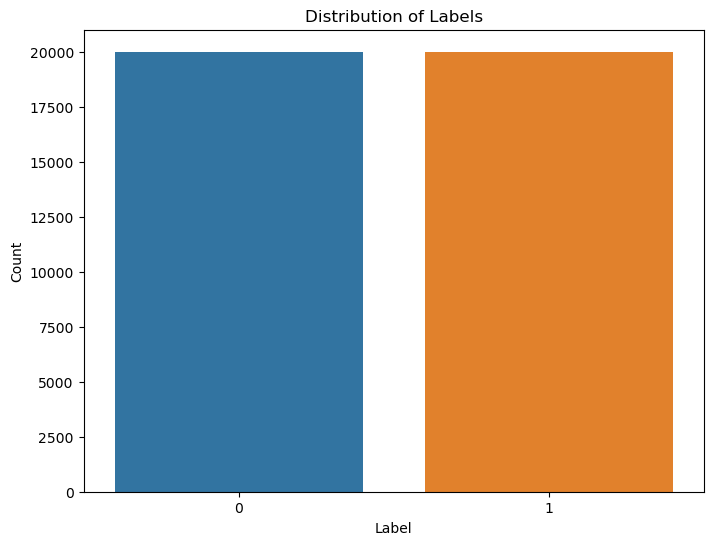

In [7]:
# Data Distribution
def plot_label_distribution(data):
    """
    Plots the distribution of labels in the dataset.
    
    Args:
    - data (DataFrame): The dataframe containing the label column.
    """
    label_distribution = data['label'].value_counts()
    print("Label Distribution:")
    print(label_distribution)

    # Plotting the distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=data)
    plt.title('Distribution of Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Call the function with your DataFrame
plot_label_distribution(data)

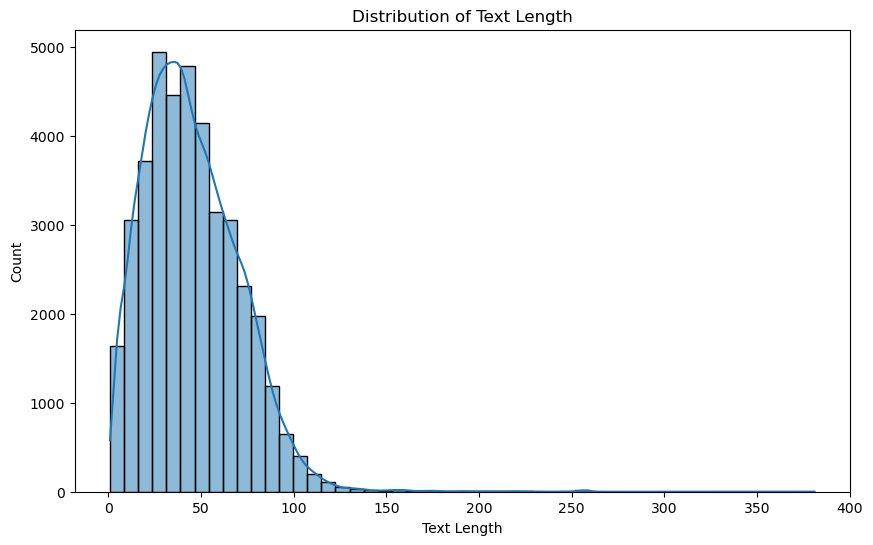

In [8]:
# Plotting text length distribution
def plot_text_length_distribution(data, text_column):
    """
    Plots the distribution of text length in the specified column of the dataset.
    
    Args:
    - data (DataFrame): The dataframe containing the text column.
    - text_column (str): The name of the text column to analyze.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data[text_column].apply(len), bins=50, kde=True)
    plt.title('Distribution of Text Length')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.show()

# Call the function with your DataFrame and text column
plot_text_length_distribution(data, 'review_text')

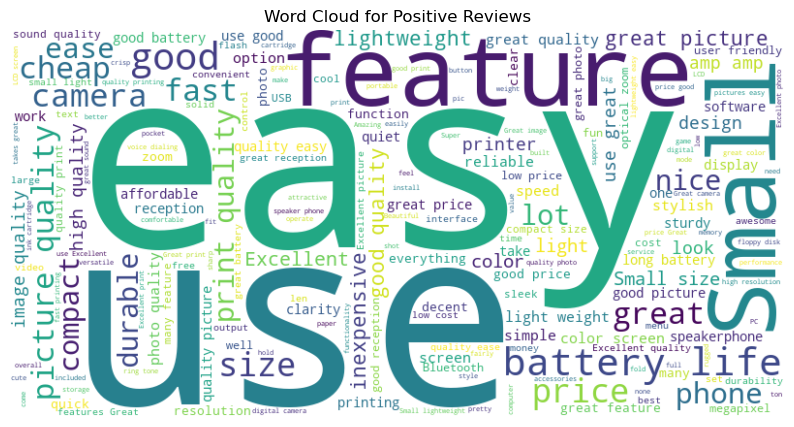

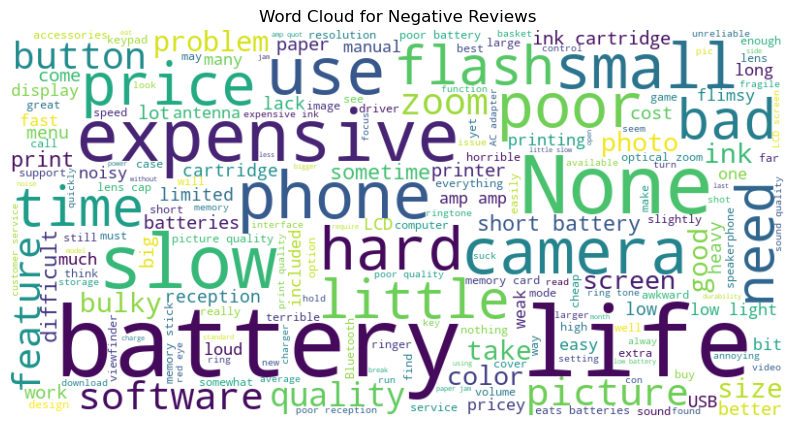

In [9]:
# Word Frequency Analysis
# Function to plot word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_wordclouds_for_sentiments(data, text_column, label_column, positive_label=1, negative_label=0):
    """
    Plots word clouds for positive and negative sentiment reviews.
    
    Args:
    - data (DataFrame): The dataframe containing the text and label columns.
    - text_column (str): The name of the column containing the text data.
    - label_column (str): The name of the column containing the labels.
    - positive_label (int): The value representing positive sentiment.
    - negative_label (int): The value representing negative sentiment.
    """
    # Extracting positive and negative reviews
    positive_reviews = ' '.join(data[data[label_column] == positive_label][text_column])
    negative_reviews = ' '.join(data[data[label_column] == negative_label][text_column])

    # Plotting word clouds for positive and negative reviews
    plot_wordcloud(positive_reviews, 'Word Cloud for Positive Reviews')
    plot_wordcloud(negative_reviews, 'Word Cloud for Negative Reviews')

# Call the function with your DataFrame and column names
plot_wordclouds_for_sentiments(data, 'review_text', 'label')

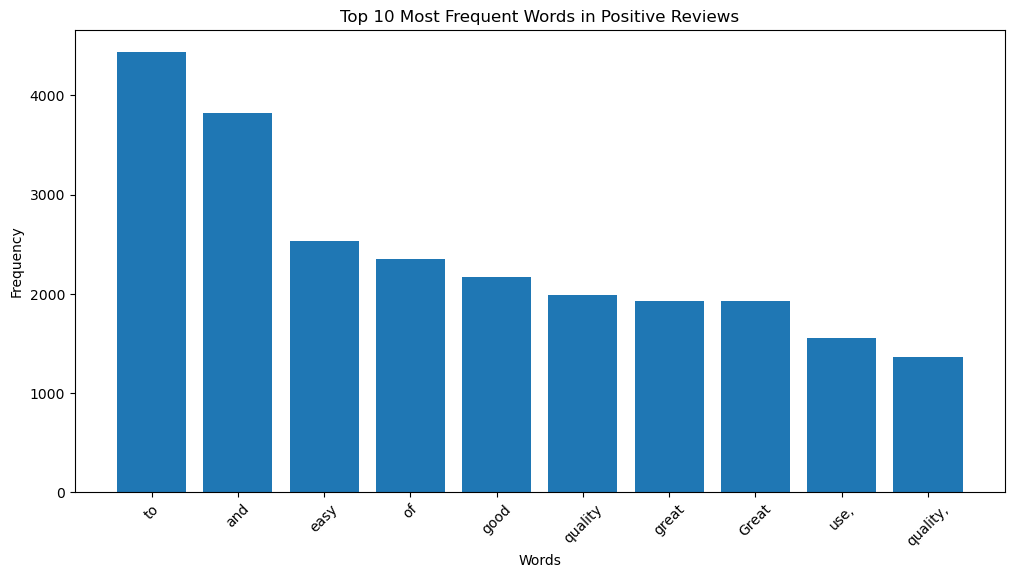

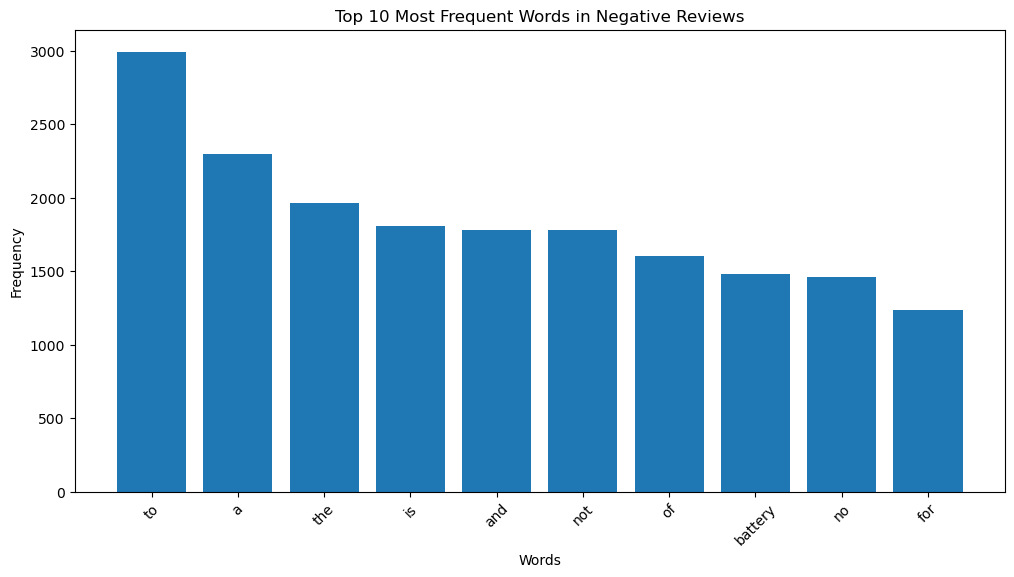

In [10]:
def plot_top_words_frequency(tokens, title):
    word_freq = Counter(tokens)
    top_words, top_freq = zip(*word_freq.most_common(10))
    
    plt.figure(figsize=(12, 6))
    plt.bar(top_words, top_freq)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Split the reviews
positive_tokens = ' '.join(data[data['label'] == 1]['review_text']).split()
negative_tokens = ' '.join(data[data['label'] == 0]['review_text']).split()

# Plot top 10 most frequent words in positive reviews
plot_top_words_frequency(positive_tokens, 'Top 10 Most Frequent Words in Positive Reviews')

# Plot top 10 most frequent words in negative reviews
plot_top_words_frequency(negative_tokens, 'Top 10 Most Frequent Words in Negative Reviews')

# <span style="color:orange">IV. Data Preprocessing</span>

## <span style="color:blue">1. Remove Irrelevant Data</span>
Remove missing values, garbage values, duplicate values, and non-necessary values


In [11]:
# Check missing values
data.isnull().sum()

review_text    0
label          0
dtype: int64

In [12]:
# Check duplicated values
data.duplicated().sum()

3448

In [13]:
# Remove duplicated values
data = pd.DataFrame(data.drop_duplicates())
data.duplicated().sum()

0

In [14]:
# Remove \n 
data['review_text'] = data['review_text'].str.strip()

In [15]:
# Check if there are N/A
none_rows = data[data['review_text'] == 'N/A']
none_rows

,review_text,label
1586,N/A,0
8625,N/A,1


In [16]:
# Check if there are n/a
none_rows = data[data['review_text'] == 'n/a']
none_rows

,review_text,label
13092,n/a,0


In [17]:
# Check if there are None 
none_rows = data[data['review_text'] == 'None']
none_rows

,review_text,label
68,None,0
664,None,1


In [18]:
# Check if there are none
none_rows = data[data['review_text'] == 'none']
none_rows

,review_text,label
89,none,0
327,none,1


In [19]:
# Check if there are nothing
none_rows = data[data['review_text'] == 'nothing']
none_rows

,review_text,label
3717,nothing,0


In [20]:
# Check if there are Nothing
none_rows = data[data['review_text'] == 'Nothing']
none_rows

,review_text,label
10733,Nothing,1
18558,Nothing,0


In [21]:
# Convert 'N/A', 'n/a','None','none','Nothing','nothing','N-O-I-S-E' to NaN value
data['review_text'] = data['review_text'].replace(['N/A', 'n/a','None','none','Nothing','nothing','N-O-I-S-E'], np.nan)

# Drop rows where 'review_text' is NaN
data = pd.DataFrame(data.dropna(subset=['review_text']))

# Print the updated DataFrame
data

,review_text,label
0,A little hard to maneuver in tight spaces.,0
1,"Poor reliability, poor reception, terrible int...",0
2,Not sure why I have to assign a speed dial num...,0
3,- Weather proof casing amp;#13; amp;#10;- 2 m...,1
4,"Big screen, good battery life, clear connectio...",1
...,...,...
39995,"Works in US and Europe, great sound quality, d...",1
39996,"No bluetooth, vibration alert too weak, slow r...",0
39997,"Small and compact, can fit just about anywhere.",1
39998,Saves Desk Space.,1


In [22]:
# Check for rows without alphabet characters in 'cleaned_review_text' column
no_alphabet_mask = ~data['review_text'].str.contains('[a-zA-Z]')

# Filter the DataFrame to keep rows without alphabet characters
data_no_alphabet = pd.DataFrame(data[no_alphabet_mask])

# Print the rows where 'cleaned_review_text' does not contain any alphabet characters
data_no_alphabet

,review_text,label
553,$$$,0
890,0,1
1465,???,0
2141,+$$$$$$$$$$,0
2622,,0
4425,1,0
5664,?,1
5982,??????????????????,0
6618,?,0
7035,...,1


In [23]:
# Check for rows with alphabet characters in 'cleaned_review_text' column
contains_alphabet_mask = data['review_text'].str.contains('[a-zA-Z]')

# Filter the DataFrame to keep rows with alphabet characters
data = pd.DataFrame(data[contains_alphabet_mask])

# Print the filtered DataFrame
data

,review_text,label
0,A little hard to maneuver in tight spaces.,0
1,"Poor reliability, poor reception, terrible int...",0
2,Not sure why I have to assign a speed dial num...,0
3,- Weather proof casing amp;#13; amp;#10;- 2 m...,1
4,"Big screen, good battery life, clear connectio...",1
...,...,...
39995,"Works in US and Europe, great sound quality, d...",1
39996,"No bluetooth, vibration alert too weak, slow r...",0
39997,"Small and compact, can fit just about anywhere.",1
39998,Saves Desk Space.,1


## <span style="color:blue">2. Text Preprocessing</span>
Define a function for text preprocessing and store the results in a new column called **'cleaned_review_text'**.

1. **Remove extra spaces**:
   - Using regular expressions, eliminate any redundant spaces within the text.

2. **Convert text to lowercase**:
   - Convert all characters in the text to lowercase to ensure uniformity.

3. **Expand contractions**:
   - Utilize the `contractions.fix()` function to expand contracted words in the text.

4. **Replace repetitions of punctuation with a single punctuation**:
   - Employ regular expressions to replace consecutive occurrences of punctuation with a single instance.

5. **Remove punctuation (except '!') and numbers**:
   - Use regular expressions to eliminate all punctuation marks and numerical digits from the text, with the exception of the exclamation mark '!'.

6. **Remove emojis**:
   - Utilize either regular expressions or a library to remove emojis from the text.

7. **Tokenize text**:
   - Segment the text into individual words or tokens using a tokenizer.

8. **Remove stop words except 'no' and 'not'**:
   - Exclude common stop words, which are words that typically do not carry significant meaning, from the text. However, retain the words 'no' and 'not' as they can alter the meaning of a sentence.

9. **Lemmatization**:
   - Apply lemmatization to reduce each word to its base or dictionary form, considering the context oent text after preprocessing.



In [24]:
def text_preprocessing(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Convert text to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Replace repetitions of punctuation with a single punctuation mark
    text = re.sub(r'(\W)\1+', r'\1', text)

    # Remove punctuation(except !) and numbers
    text = re.sub(r'[^a-zA-Z!]+', ' ', text)

    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Tokenize text using SpaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stop words except 'no' and 'not' - SpaCy has its own stop words list
    tokens = [token for token in tokens if not nlp.vocab[token].is_stop or token in {'no', 'not'}]

    # Lemmatization - SpaCy performs lemmatization automatically
    tokens = [token.lemma_ for token in doc]

    # Return Join tokens back into text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Apply the function to the 'review_text' column and store the results in a new column 'cleaned_review_text'
data['cleaned_review_text'] = data['review_text'].apply(text_preprocessing)

data

,review_text,label,cleaned_review_text
0,A little hard to maneuver in tight spaces.,0,a little hard to maneuver in tight space
1,"Poor reliability, poor reception, terrible int...",0,poor reliability poor reception terrible inter...
2,Not sure why I have to assign a speed dial num...,0,not sure why I have to assign a speed dial num...
3,- Weather proof casing amp;#13; amp;#10;- 2 m...,1,weather proof case amp amp megapixels resolu...
4,"Big screen, good battery life, clear connectio...",1,big screen good battery life clear connection ...
...,...,...,...
39995,"Works in US and Europe, great sound quality, d...",1,work in we and europe great sound quality durable
39996,"No bluetooth, vibration alert too weak, slow r...",0,no bluetooth vibration alert too weak slow res...
39997,"Small and compact, can fit just about anywhere.",1,small and compact can fit just about anywhere
39998,Saves Desk Space.,1,save desk space


## <span style="color:blue">3. Feature Extraction</span>

Feature extraction is a process in which relevant information is extracted from raw data to create new features that are more informative and suitable for machine learning algorithms. This step is crucial for improving the performance of models by reducing dimensionality, removing noise, and highlighting important patterns in the data.


### <span style="color:green">a. Count of Positive and Negative Words in Review Text</span>
This analysis provides a breakdown of the number of positive and negative words found in the review text. Positive and negative sentiments are quantified to gain insights into the overall tone of the reviews.

In [25]:
def count_positive_words(cleaned_review_text):
    positive_words = set()
    with open('Datasets/positive-words.txt', 'r', encoding='latin-1') as f:
        positive_words = set(f.read().splitlines())
    words = cleaned_review_text.split()
    count = sum(1 for word in words if word in positive_words)
    return count

def count_negative_words(cleaned_review_text):
    negative_words = set()
    with open('Datasets/negative-words.txt', 'r', encoding='latin-1') as f:
        negative_words = set(f.read().splitlines())
    words = cleaned_review_text.split()
    count = sum(1 for word in words if word in negative_words)
    return count

In [26]:
# Apply function count_positive_words and count_negative_words to cleaned_review_text
data['count_positive_words'] = data['cleaned_review_text'].apply(count_positive_words)
data['count_negative_words'] = data['cleaned_review_text'].apply(count_negative_words)

In [27]:
data.head(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words
0,A little hard to maneuver in tight spaces.,0,a little hard to maneuver in tight space,0,1
1,"Poor reliability, poor reception, terrible int...",0,poor reliability poor reception terrible inter...,0,5
2,Not sure why I have to assign a speed dial num...,0,not sure why I have to assign a speed dial num...,0,0
3,- Weather proof casing amp;#13; amp;#10;- 2 m...,1,weather proof case amp amp megapixels resolu...,0,0
4,"Big screen, good battery life, clear connectio...",1,big screen good battery life clear connection ...,2,0
5,"Size, Paper Jams, Hard to change ink cartridge...",0,size paper jam hard to change ink cartridge lo...,0,4
6,Print cartridges are expensive.,0,print cartridge be expensive,0,1
7,"Fat antenna, side buttons beep when anything h...",0,fat antenna side button beep when anything hit...,0,2
8,quick black printing,1,quick black printing,0,0
9,can pull in a signal where others can't.,1,can pull in a signal where other can not,0,0


### <span style="color:green">b. Check for Presence of 'no' or 'not' in Review Text</span>
This analysis examines whether the review text includes the words 'no' or 'not'. Identifying the presence of these words can be crucial for understanding negation in the sentiment expressed within the reviews.
views.


In [28]:
def contain_no(cleaned_review_text):
    tokens = cleaned_review_text.split()
    contain_no = int('no' in tokens)
    return contain_no

def contain_not(cleaned_review_text):
    tokens = cleaned_review_text.split()
    contain_not = int('not' in tokens)
    return contain_not

In [29]:
# Apply function contains_no and contains_not to cleaned_review_text
data['contain_no'] = data['cleaned_review_text'].apply(contain_no)
data['contain_not'] = data['cleaned_review_text'].apply(contain_not)

In [30]:
data.tail(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not
39990,Workhorse disguised as a cool techie toy,1,workhorse disguise as a cool techie toy,1,0,0,0
39991,Selectable ring tones for different people,1,selectable ring tone for different people,0,0,0,0
39992,"99 number memory, good voice quality, and one ...",1,number memory good voice quality and one hel...,1,1,0,0
39993,Ease of operation and handling.,1,ease of operation and handle,1,0,0,0
39994,Downloading to computer is a little tricky!!,0,download to computer be a little tricky !,0,1,0,0
39995,"Works in US and Europe, great sound quality, d...",1,work in we and europe great sound quality durable,3,0,0,0
39996,"No bluetooth, vibration alert too weak, slow r...",0,no bluetooth vibration alert too weak slow res...,0,3,1,0
39997,"Small and compact, can fit just about anywhere.",1,small and compact can fit just about anywhere,1,0,0,0
39998,Saves Desk Space.,1,save desk space,0,0,0,0
39999,very clear photos,1,very clear photo,1,0,0,0


### <span style="color:green">c. Check for Presence of '!' in Review Text</span>
This analysis looks for the presence of the exclamation mark '!' within the review text. The presence of '!' can indicate emphasis or heightened emotion in the expressed sentiments.

In [31]:
def contain_exclamation(cleaned_review_text):
    tokens = cleaned_review_text.split()
    contain_exclamation = int('!' in tokens)
    return contain_exclamation

In [32]:
# Apply function contain_exclamation to cleaned_review_text
data['contain_exclamation'] = data['cleaned_review_text'].apply(contain_exclamation)

In [33]:
data.tail(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation
39990,Workhorse disguised as a cool techie toy,1,workhorse disguise as a cool techie toy,1,0,0,0,0
39991,Selectable ring tones for different people,1,selectable ring tone for different people,0,0,0,0,0
39992,"99 number memory, good voice quality, and one ...",1,number memory good voice quality and one hel...,1,1,0,0,0
39993,Ease of operation and handling.,1,ease of operation and handle,1,0,0,0,0
39994,Downloading to computer is a little tricky!!,0,download to computer be a little tricky !,0,1,0,0,1
39995,"Works in US and Europe, great sound quality, d...",1,work in we and europe great sound quality durable,3,0,0,0,0
39996,"No bluetooth, vibration alert too weak, slow r...",0,no bluetooth vibration alert too weak slow res...,0,3,1,0,0
39997,"Small and compact, can fit just about anywhere.",1,small and compact can fit just about anywhere,1,0,0,0,0
39998,Saves Desk Space.,1,save desk space,0,0,0,0,0
39999,very clear photos,1,very clear photo,1,0,0,0,0


### <span style="color:green">d. Log of Review Text Length</span>
This analysis calculates the logarithm of the length of the review text. Taking the logarithm of the length can help normalize the data and highlight differences in text length more effectively.


In [34]:
def log_review_length(review_text):
    review_length = len(review_text)
    if review_length == 0:
        return 0  # Return 0 if the review length is 0
    log_length = math.log(review_length)
    return log_length

In [35]:
# Apply function log_review_length to cleaned_review_text
data['log_review_length'] = data['cleaned_review_text'].apply(log_review_length)

In [36]:
data.head(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length
0,A little hard to maneuver in tight spaces.,0,a little hard to maneuver in tight space,0,1,0,0,0,3.688879
1,"Poor reliability, poor reception, terrible int...",0,poor reliability poor reception terrible inter...,0,5,0,0,0,4.290459
2,Not sure why I have to assign a speed dial num...,0,not sure why I have to assign a speed dial num...,0,0,0,1,0,4.304065
3,- Weather proof casing amp;#13; amp;#10;- 2 m...,1,weather proof case amp amp megapixels resolu...,0,0,0,0,0,4.304065
4,"Big screen, good battery life, clear connectio...",1,big screen good battery life clear connection ...,2,0,0,0,0,4.094345
5,"Size, Paper Jams, Hard to change ink cartridge...",0,size paper jam hard to change ink cartridge lo...,0,4,0,0,0,3.970292
6,Print cartridges are expensive.,0,print cartridge be expensive,0,1,0,0,0,3.332205
7,"Fat antenna, side buttons beep when anything h...",0,fat antenna side button beep when anything hit...,0,2,0,0,0,4.276666
8,quick black printing,1,quick black printing,0,0,0,0,0,2.995732
9,can pull in a signal where others can't.,1,can pull in a signal where other can not,0,0,0,1,0,3.688879


### <span style="color:green">e. Emotion Label Based on Review Text</span>
This analysis assigns an emotion label to each review text based on the predominant emotion expressed. Emotions such as joy, sadness, anger, surprise, and others may be identified using sentiment analysis techniques, helping to categorize the overall emotional tone of the reviews.


In [37]:
def get_emotion_label(phrase):
    # Tokenize the phrase
    tokens = phrase.split()

    # Define emotion word list
    emotion_words = []

    for i in range(len(tokens)):
      # Call NRCLex constructor
      emotion = NRCLex(tokens[i])
      # Get affect_dict
      affect_dict = emotion.affect_dict
      # Extract emotion words from affect_dict values
      for sublist in affect_dict.values():
        emotion_words.extend(sublist)

    # Define positive and negative emotion groups
    positive_emotions = ['anticipation', 'trust', 'positive', 'joy', 'surprise']
    negative_emotions = ['fear', 'anger', 'negative', 'sadness', 'disgust']

    # Count occurrences of positive and negative words
    positive_count = sum(emotion_words.count(emotion) for emotion in positive_emotions)
    negative_count = sum(emotion_words.count(emotion) for emotion in negative_emotions)

    # Determine sentiment label based on counts
    if positive_count > negative_count:
        return 1
    elif positive_count < negative_count:
        return 0
    else:
        return 2

# Sample usage
phrase = "This movie is great and wonderful, but it made me sad."
emotion_label = get_emotion_label(phrase)
print("Emotion label:", emotion_label)

Emotion label: 1


In [38]:
# Apply function get_emotion_label to cleaned_review_text
data['emotion_label'] = data['cleaned_review_text'].apply(get_emotion_label)

In [39]:
data.head(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label
0,A little hard to maneuver in tight spaces.,0,a little hard to maneuver in tight space,0,1,0,0,0,3.688879,2
1,"Poor reliability, poor reception, terrible int...",0,poor reliability poor reception terrible inter...,0,5,0,0,0,4.290459,0
2,Not sure why I have to assign a speed dial num...,0,not sure why I have to assign a speed dial num...,0,0,0,1,0,4.304065,2
3,- Weather proof casing amp;#13; amp;#10;- 2 m...,1,weather proof case amp amp megapixels resolu...,0,0,0,0,0,4.304065,0
4,"Big screen, good battery life, clear connectio...",1,big screen good battery life clear connection ...,2,0,0,0,0,4.094345,1
5,"Size, Paper Jams, Hard to change ink cartridge...",0,size paper jam hard to change ink cartridge lo...,0,4,0,0,0,3.970292,0
6,Print cartridges are expensive.,0,print cartridge be expensive,0,1,0,0,0,3.332205,0
7,"Fat antenna, side buttons beep when anything h...",0,fat antenna side button beep when anything hit...,0,2,0,0,0,4.276666,0
8,quick black printing,1,quick black printing,0,0,0,0,0,2.995732,0
9,can pull in a signal where others can't.,1,can pull in a signal where other can not,0,0,0,1,0,3.688879,1


### <span style="color:green">f. Sentiment Score Calculation</span>
This analysis computes the sentiment score for each review text. The sentiment score quantifies the overall sentiment expressed in the review, typically ranging from negative to positive values.


In [40]:
def calculate_sentiment_score(phrase):
    # Create a TextBlob object
    blob = TextBlob(phrase)

    # Get the sentiment score
    sentiment_score = blob.sentiment.polarity

    return sentiment_score

# Sample usage
phrase = "This movie is great and wonderful, but it made me sad."
sentiment_score = calculate_sentiment_score(phrase)
print("Sentiment score:", sentiment_score)

Sentiment score: 0.43333333333333335


In [41]:
# Apply function calculate_sentiment_score to cleaned_review_text
data['sentiment_score'] = data['cleaned_review_text'].apply(calculate_sentiment_score)

In [42]:
data.head(10)

,review_text,label,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score
0,A little hard to maneuver in tight spaces.,0,a little hard to maneuver in tight space,0,1,0,0,0,3.688879,2,-0.219246
1,"Poor reliability, poor reception, terrible int...",0,poor reliability poor reception terrible inter...,0,5,0,0,0,4.290459,0,-0.625000
2,Not sure why I have to assign a speed dial num...,0,not sure why I have to assign a speed dial num...,0,0,0,1,0,4.304065,2,-0.250000
3,- Weather proof casing amp;#13; amp;#10;- 2 m...,1,weather proof case amp amp megapixels resolu...,0,0,0,0,0,4.304065,0,0.000000
4,"Big screen, good battery life, clear connectio...",1,big screen good battery life clear connection ...,2,0,0,0,0,4.094345,1,0.266667
5,"Size, Paper Jams, Hard to change ink cartridge...",0,size paper jam hard to change ink cartridge lo...,0,4,0,0,0,3.970292,0,-0.163889
6,Print cartridges are expensive.,0,print cartridge be expensive,0,1,0,0,0,3.332205,0,-0.500000
7,"Fat antenna, side buttons beep when anything h...",0,fat antenna side button beep when anything hit...,0,2,0,0,0,4.276666,0,0.000000
8,quick black printing,1,quick black printing,0,0,0,0,0,2.995732,0,0.083333
9,can pull in a signal where others can't.,1,can pull in a signal where other can not,0,0,0,1,0,3.688879,1,-0.125000


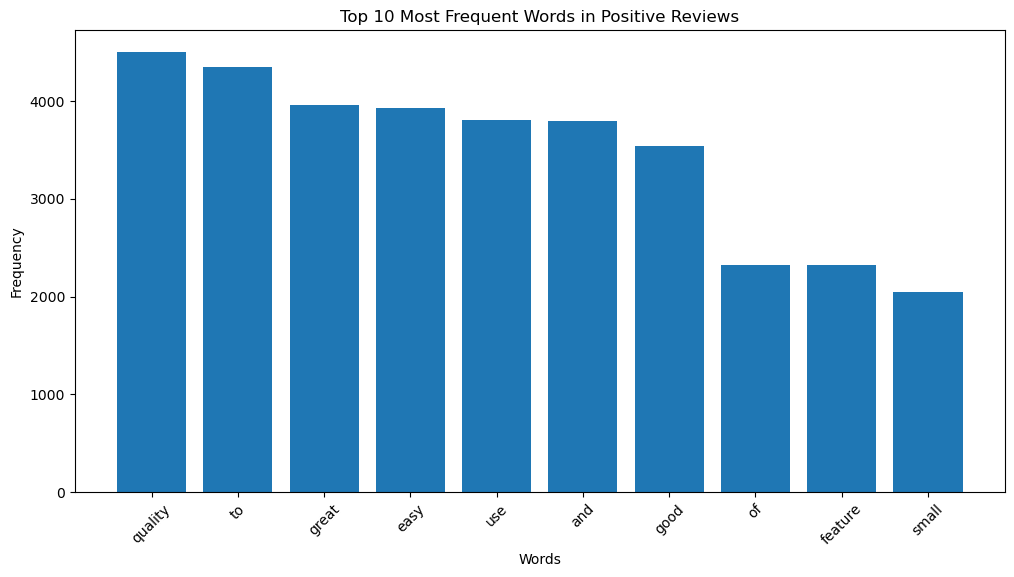

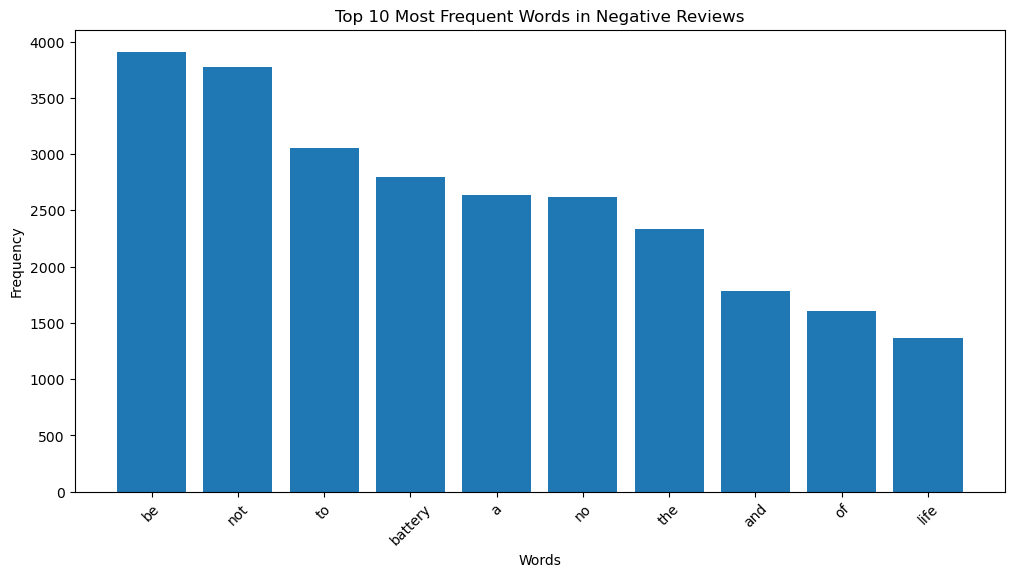

In [43]:
# Split the reviews
positive_tokens = ' '.join(data[data['label'] == 1]['cleaned_review_text']).split()
negative_tokens = ' '.join(data[data['label'] == 0]['cleaned_review_text']).split()

# Plot top 10 most frequent words in positive reviews
plot_top_words_frequency(positive_tokens, 'Top 10 Most Frequent Words in Positive Reviews')

# Plot top 10 most frequent words in negative reviews
plot_top_words_frequency(negative_tokens, 'Top 10 Most Frequent Words in Negative Reviews')

Label Distribution:
label
1    18704
0    17806
Name: count, dtype: int64


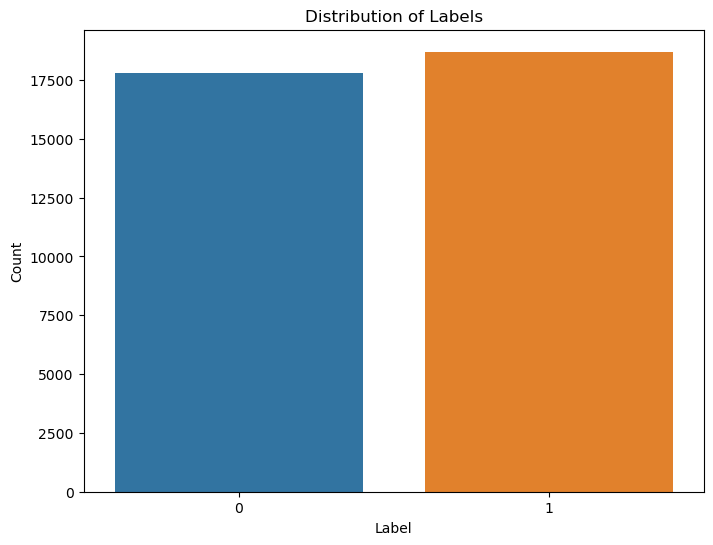

In [44]:
# Plot label distribution
plot_label_distribution(data)

## <span style="color:blue">3. Data Preparation</span>

Data preparation splitting the dataset into training and test sets, typically using 80% of the data for training and 20% for testing.

**Stratified** sampling is a sampling method in which the population is divided into subgroups or strata, and a sample is taken from each stratum. This method is used when the population includes different subgroups that are important to the study, and it is important to ensure that each subgroup is represented in the sample. The goal of stratified sampling is to ensure that the sample is representative of the entire population by ensuring that each subgroup is adequately represented.

In the context of train_test_split, stratified sampling can be useful when dealing with imbalanced datasets to ensure that the training and test datasets have the same proportion of class labels as the input dataset.

In [45]:
# Splitting the data into features (X) and labels (y)
X = data.drop(columns=['review_text', 'label'])
y = data['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
# Combining X_test and y_test into a single dataframe
test_data = pd.concat([X_test, y_test], axis=1)
test_data

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score,label
29882,low light be blurry flash be too much sometime...,1,1,0,1,0,4.110874,2,0.150000,0
8454,battery life buzz near tv and phone and long s...,0,0,0,0,0,4.077537,2,0.025000,0
36508,flimsy easily break head get misalign often,0,3,0,0,0,3.761200,1,0.433333,0
37706,great cheap,1,1,0,0,0,2.397895,0,0.600000,1
19794,easy to install excellent operation great colo...,3,0,0,0,0,3.970292,1,0.744444,1
...,...,...,...,...,...,...,...,...,...,...
26999,great picture quick download to my pc usb conn...,1,0,0,0,0,4.077537,1,0.566667,1
30184,super low price of mb memory aa battery operat...,1,0,0,0,0,4.174387,0,0.111111,1
1085,great battery life,1,0,0,0,0,2.890372,0,0.800000,1
2049,very light,0,0,0,0,0,2.302585,2,0.520000,1


Label Distribution:
label
1    3741
0    3561
Name: count, dtype: int64


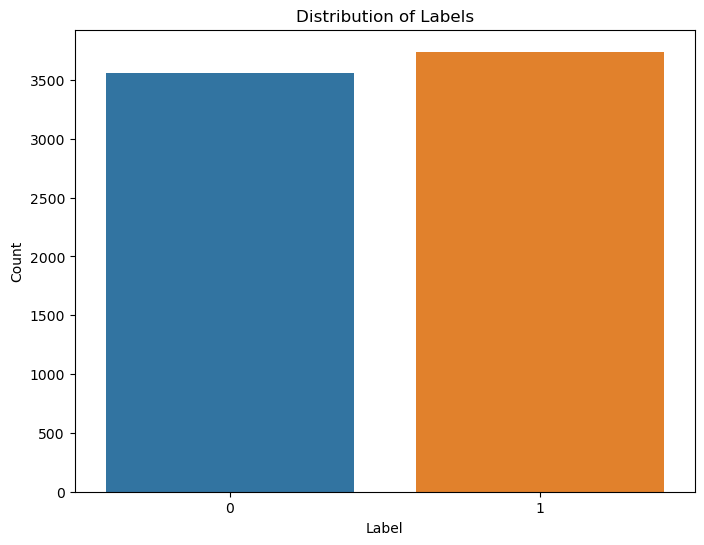

In [47]:
# Plot label distribution
plot_label_distribution(test_data)

In [48]:
# Combining X_train and y_train into a single dataframe
train_data = pd.concat([X_train, y_train], axis=1)
train_data

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score,label
11250,unreliable jam support do not help ink be very...,1,3,0,1,0,4.025352,1,-0.650000,0
11337,very user friendly right price for the service...,3,0,0,0,0,4.219508,1,0.332143,1
18365,size dependability,0,0,0,0,0,2.890372,2,0.000000,1
39780,great quality for the price,1,0,0,0,0,3.295837,2,0.800000,1
10164,great picture lens and feature,1,0,0,0,0,3.401197,1,0.800000,1
...,...,...,...,...,...,...,...,...,...,...
20047,great pic small size optical zoom,1,0,0,0,0,3.496508,0,0.275000,1
20157,reception camera,0,0,0,0,0,2.772589,2,0.000000,0
13239,free camera medium net external screen sound r...,1,0,0,0,0,3.931826,2,0.200000,1
11376,reception be okay no automatic flash for camer...,0,0,1,0,0,4.394449,1,0.500000,0


Label Distribution:
label
1    14963
0    14245
Name: count, dtype: int64


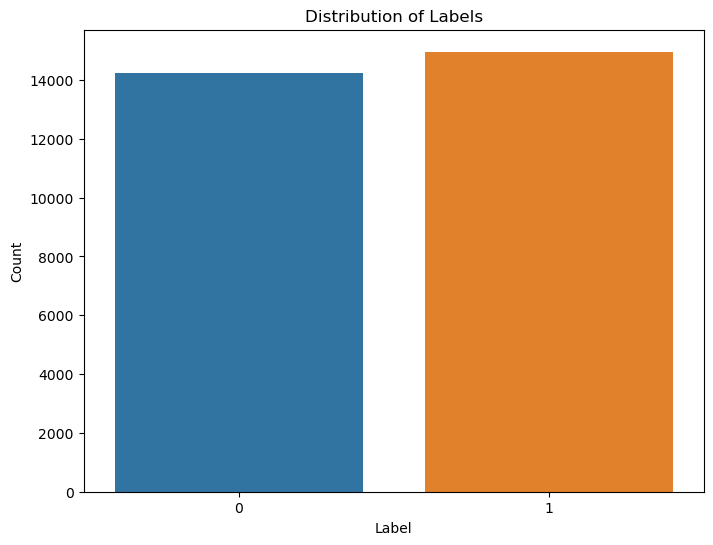

In [49]:
# Plot label distribution
plot_label_distribution(train_data)

## <span style="color:blue">4. Data Balancing</span>

**Data balancing** is a process used to address class **imbalance** in a dataset, where one class is significantly more prevalent than others. This imbalance can lead to biased model performance, with the majority class dominating predictions. Techniques such as **oversampling** the minority class, **undersampling** the majority class, or using synthetic data generation methods can help balance the dataset and improve the model's ability to generalize across all classes.

It's important to always split the dataset into training and testing sets before balancing the data. That way, it ensures that the test dataset is as unbiased as it can be and reflects a true evaluation for the models.



***RandomUnderSampler*** involves randomly selecting examples from the majority class and deleting them from the training dataset. In the random under-sampling, the majority class instances are discarded at random until a more balanced distribution is reached.

In [50]:
# Creating an instance of RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Balancing the training data using RandomUnderSampler
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

In [51]:
# Combining X_train and y_train into a single dataframe
train_data = pd.concat([X_train_balanced, y_train_balanced], axis=1)
train_data

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score,label
11250,unreliable jam support do not help ink be very...,1,3,0,1,0,4.025352,1,-0.650000,0
7919,fail to charge silence itself randomly lousy r...,0,3,0,0,0,4.110874,1,-0.333333,0
5446,wobble wheel no adequate sunshade,1,1,1,0,0,3.496508,2,-0.166667,0
38753,hard to find install and software have some issue,0,2,0,0,0,3.891820,1,-0.291667,0
10937,inside flash sometimes not great eat up batter...,2,0,0,1,0,3.951244,0,-0.100000,0
...,...,...,...,...,...,...,...,...,...,...
33184,cool lcd fair picture quality twain interface,2,0,0,0,0,3.806662,1,0.525000,1
31318,crystal clear mp image x optical zoom long bat...,2,0,0,0,0,4.330733,1,0.283333,1
9672,small metal,0,0,0,0,0,2.397895,0,-0.250000,1
27060,cheap fast excellent print quality,2,1,0,0,0,3.526361,1,0.533333,1


Label Distribution:
label
0    14245
1    14245
Name: count, dtype: int64


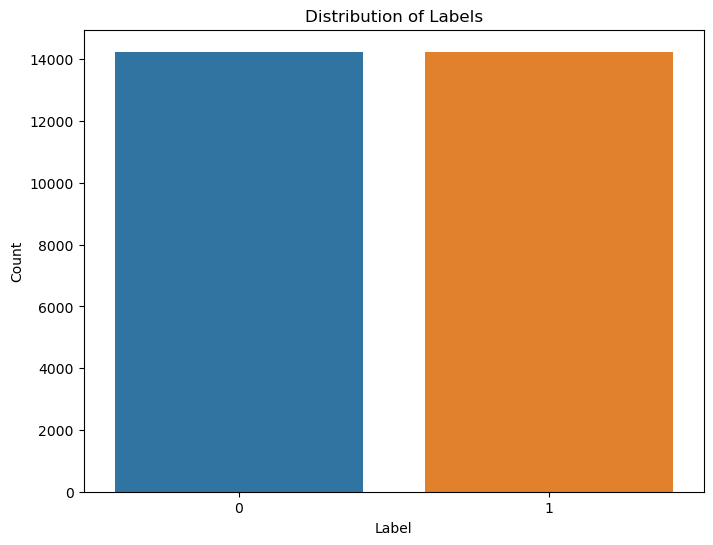

In [52]:
# Plot label distribution
plot_label_distribution(train_data)

## <span style="color:blue">5. Feature Scaling ( numerical features )</span>
***Feature scaling*** is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

***MinMaxScaler*** shrinks the data within the given range, usually of 0 to 1. It transforms data by scaling features to a given range. It scales the values to a specific value range without changing the shape of the original distribution.

In [53]:
# assign variable names to the columns containing numerical data and text data
numerical_columns = ['count_positive_words', 'count_negative_words', 'contain_no', 'contain_not',
                     'contain_exclamation', 'log_review_length', 'emotion_label', 'sentiment_score']

text_columns = ['cleaned_review_text']

In [54]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_balanced[numerical_columns] = scaler.fit_transform(X_train_balanced[numerical_columns])

# Transform the test data (using the same scaler fitted on the training data)
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [55]:
X_train_balanced

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score
11250,unreliable jam support do not help ink be very...,0.1,0.375,0.0,1.0,0.0,0.662408,0.5,0.175000
7919,fail to charge silence itself randomly lousy r...,0.0,0.375,0.0,0.0,0.0,0.679409,0.5,0.333333
5446,wobble wheel no adequate sunshade,0.1,0.125,1.0,0.0,0.0,0.557280,1.0,0.416667
38753,hard to find install and software have some issue,0.0,0.250,0.0,0.0,0.0,0.635864,0.5,0.354167
10937,inside flash sometimes not great eat up batter...,0.2,0.000,0.0,1.0,0.0,0.647677,0.0,0.450000
...,...,...,...,...,...,...,...,...,...
33184,cool lcd fair picture quality twain interface,0.2,0.000,0.0,0.0,0.0,0.618935,0.5,0.762500
31318,crystal clear mp image x optical zoom long bat...,0.2,0.000,0.0,0.0,0.0,0.723115,0.5,0.641667
9672,small metal,0.0,0.000,0.0,0.0,0.0,0.338887,0.0,0.375000
27060,cheap fast excellent print quality,0.2,0.125,0.0,0.0,0.0,0.563214,0.5,0.766667


In [56]:
X_test

,cleaned_review_text,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score
29882,low light be blurry flash be too much sometime...,0.1,0.125,0.0,1.0,0.0,0.679409,1.0,0.575000
8454,battery life buzz near tv and phone and long s...,0.0,0.000,0.0,0.0,0.0,0.672782,1.0,0.512500
36508,flimsy easily break head get misalign often,0.0,0.375,0.0,0.0,0.0,0.609898,0.5,0.716667
37706,great cheap,0.1,0.125,0.0,0.0,0.0,0.338887,0.0,0.800000
19794,easy to install excellent operation great colo...,0.3,0.000,0.0,0.0,0.0,0.651463,0.5,0.872222
...,...,...,...,...,...,...,...,...,...
26999,great picture quick download to my pc usb conn...,0.1,0.000,0.0,0.0,0.0,0.672782,0.5,0.783333
30184,super low price of mb memory aa battery operat...,0.1,0.000,0.0,0.0,0.0,0.692035,0.0,0.555556
1085,great battery life,0.1,0.000,0.0,0.0,0.0,0.436786,0.0,0.900000
2049,very light,0.0,0.000,0.0,0.0,0.0,0.319940,1.0,0.760000


## <span style="color:blue">6. Feature Encoding</span>
Machine learning models can only work with numerical values. For this reason, it is necessary to transform the categorical values of the relevant features into numerical ones. This process is called feature encoding. Data frame analytics automatically performs ***feature encoding***.

***TfidfVectorizer*** : Term frequency Inverse document frequency (TFIDF) is a statistical formula to convert text documents into vectors based on the relevancy of the word. It is based on the bag of the words model to create a matrix containing the information about less relevant and most relevant words in the document.

In [57]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train_text_tfidf = tfidf_vectorizer.fit_transform(X_train_balanced['cleaned_review_text'])

# Transform the test data using the vocabulary learned from the training data
X_test_text_tfidf = tfidf_vectorizer.transform(X_test['cleaned_review_text'])

# Convert numerical features to sparse matrix
X_train_numeric_sparse = csr_matrix(X_train_balanced[numerical_columns].values)
X_test_numeric_sparse = csr_matrix(X_test[numerical_columns].values)

# Concatenate the TF-IDF transformed text features and numerical features
X_train = hstack([X_train_text_tfidf, X_train_numeric_sparse])
X_test = hstack([X_test_text_tfidf, X_test_numeric_sparse])

print("Shape of concatenated feature matrix for training set:", X_train.shape)
print("Shape of concatenated feature matrix for test set:", X_test.shape)

Shape of concatenated feature matrix for training set: (28490, 6252)
Shape of concatenated feature matrix for test set: (7302, 6252)


# <span style="color:orange">V. Modeling</span>
In supervised learning, a model is the complex collection of numbers that define the mathematical relationship from specific input feature patterns to specific output label values. The model discovers these patterns through training.

***Training*** : Before a supervised model can make predictions, it must be trained. To train a model, we give the model a dataset with labeled examples. The model's goal is to work out the best solution for predicting the labels from the features. The model finds the best solution by comparing its predicted value to the label's actual value. In other words, the model learns the mathematical relationship between the features and the label so that it can make the best predictions on unseen data.

## <span style="color:blue">1. Random Forest</span>

***Random Forest Classification*** is a robust and versatile machine learning method for categorizing data. By leveraging an ensemble of decision trees, it achieves high accuracy and avoids overfitting, making it a popular choice for various classification tasks.

In [58]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier()

In [59]:
# Train the classifier
rf_classifier.fit(X_train, y_train_balanced)

RandomForestClassifier()

In [60]:
# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

In [61]:
# Check True Value vs Predicted Value on Test Set
classification_data = pd.DataFrame(zip(y_test, y_pred_rf),columns=['True Value','Predicted Value'])
classification_data

,True Value,Predicted Value
0,0,0
1,0,1
2,0,0
3,1,1
4,1,1
...,...,...
7297,1,1
7298,1,1
7299,1,1
7300,1,1


In [62]:
# Check the test score and train score for the model
test_score = rf_classifier.score(X_test, y_test)
train_score = rf_classifier.score(X_train, y_train_balanced)

print(f'The RandomForestClassifier model test score is {test_score * 100:.2f}%')
print(f'The RandomForestClassifier model train score is {train_score * 100:.2f}%')

The RandomForestClassifier model test score is 93.41%
The RandomForestClassifier model train score is 99.53%


## <span style="color:blue">2. Multinomial Naive Bayes (MultinomialNB)</span>

***Multinomial Naive Bayes (MNB)*** is a classification algorithm commonly used in tasks involving text data, like Natural Language Processing (NLP). It's based on the concept of Bayes' theorem and makes predictions based on probabilities.

In [63]:
# Initialize the MultinomialNB
mnb_classifier = MultinomialNB()

In [64]:
# Train the classifier
mnb_classifier.fit(X_train, y_train_balanced)

MultinomialNB()

In [65]:
# Make predictions on the test set
y_pred_mnb = mnb_classifier.predict(X_test)

In [66]:
# Check True Value vs Predicted Value on Test Set
classification_data = pd.DataFrame(zip(y_test, y_pred_mnb),columns=['True Value','Predicted Value'])
classification_data

,True Value,Predicted Value
0,0,0
1,0,0
2,0,0
3,1,1
4,1,1
...,...,...
7297,1,1
7298,1,1
7299,1,1
7300,1,1


In [67]:
# Check the test score and train score for the model
test_score = mnb_classifier.score(X_test, y_test)
train_score = mnb_classifier.score(X_train, y_train_balanced)

print(f'The Multinomial Naive Bayes (MultinomialNB) model test score is {test_score * 100:.2f}%')
print(f'The Multinomial Naive Bayes (MultinomialNB) model train score is {train_score * 100:.2f}%')

The Multinomial Naive Bayes (MultinomialNB) model test score is 92.45%
The Multinomial Naive Bayes (MultinomialNB) model train score is 93.40%


## <span style="color:blue">3. Support Vector Machine (SVM)</span>

***Support Vector Machine (SVM) for Classification***  are a powerful set of supervised learning algorithms  widely used for classification tasks. They excel at finding the optimal separation hyperplane between different classes in high-dimensional spaces. 

In [68]:
# Create an instance of the SVM classifier
svm_classifier = SVC()

In [69]:
# Train the classifier
svm_classifier.fit(X_train, y_train_balanced)

SVC()

In [70]:
# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

In [71]:
# Check True Value vs Predicted Value on Test Set
classification_data = pd.DataFrame(zip(y_test, y_pred_svm),columns=['True Value','Predicted Value'])
classification_data

,True Value,Predicted Value
0,0,0
1,0,1
2,0,0
3,1,1
4,1,1
...,...,...
7297,1,1
7298,1,1
7299,1,1
7300,1,1


In [72]:
# Check the test score and train score for the model
test_score = svm_classifier.score(X_test, y_test)
train_score = svm_classifier.score(X_train, y_train_balanced)

print(f'The Support Vector Machine (SVM) model test score is {test_score * 100:.2f}%')
print(f'The Support Vector Machine (SVM) model train score is {train_score * 100:.2f}%')

The Support Vector Machine (SVM) model test score is 94.41%
The Support Vector Machine (SVM) model train score is 96.82%


## <span style="color:blue">4. Logistic Regression </span>

***logistic regression*** is a powerful and versatile tool for binary classification tasks. Its simplicity, interpretability, efficiency, and probabilistic outputs make it a popular choice for various machine learning applications.

In [73]:
# Create an instance of the Logistic Regression classifier
l_classifier = LogisticRegression(max_iter=1000, random_state=42)

In [74]:
# Train the classifier
l_classifier.fit(X_train, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

In [75]:
# Make predictions on the test set
y_pred_l = l_classifier.predict(X_test)

In [76]:
# Check True Value vs Predicted Value on Test Set
classification_data = pd.DataFrame(zip(y_test, y_pred_l),columns=['True Value','Predicted Value'])
classification_data

,True Value,Predicted Value
0,0,0
1,0,1
2,0,0
3,1,1
4,1,1
...,...,...
7297,1,1
7298,1,1
7299,1,1
7300,1,1


In [77]:
# Check the test score and train score for the model
test_score = l_classifier.score(X_test, y_test)
train_score = l_classifier.score(X_train, y_train_balanced)

print(f'The Logistic Regression model test score is {test_score * 100:.2f}%')
print(f'The Logistic Regression model train score is {train_score * 100:.2f}%')

The Logistic Regression model test score is 93.67%
The Logistic Regression model train score is 94.53%


# <span style="color:orange">VI. Evaluation</span>
The process of evaluating a trained model determines how well it learned. This involves using a labeled dataset. The model receives only the features (data points) from the dataset. The model's predictions are then compared to the true values of the labels to assess its performance.

## <span style="color:blue">1. Random Forest</span>

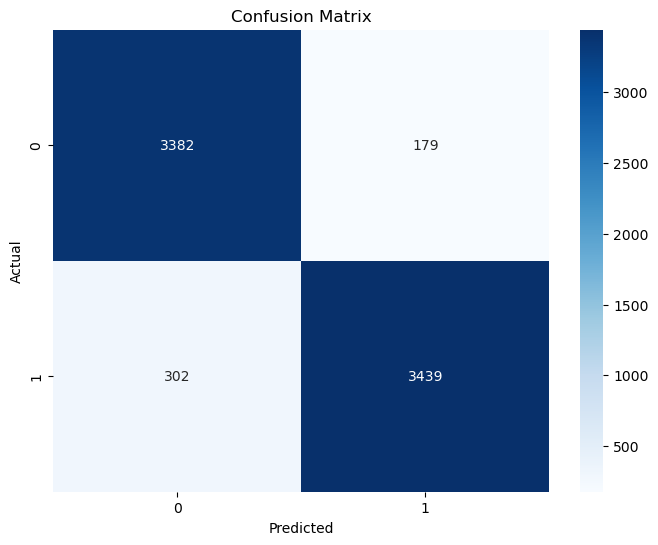

In [78]:
# Evaluate the performance of the model
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [79]:
# Print the formatted classification report
class_report = classification_report(y_test, y_pred_rf)
print("\tRandomForest Classification Report:\n\n", class_report)

	RandomForest Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.95      0.93      3561
           1       0.95      0.92      0.93      3741

    accuracy                           0.93      7302
   macro avg       0.93      0.93      0.93      7302
weighted avg       0.93      0.93      0.93      7302



## <span style="color:blue">2. Multinomial Naive Bayes (MultinomialNB)</span>

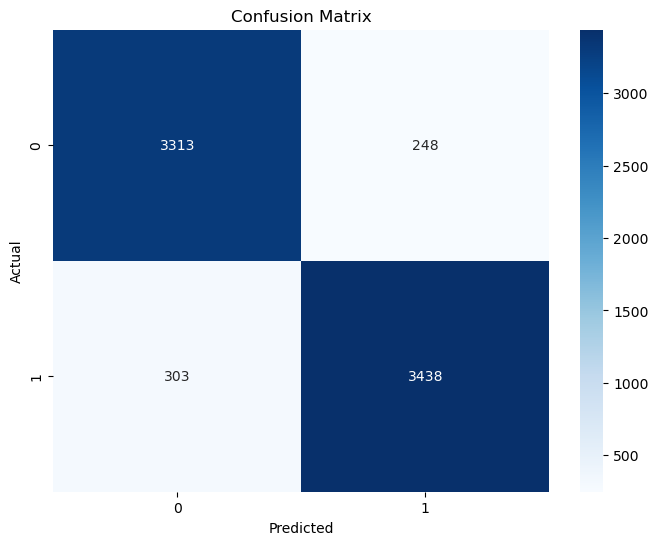

In [80]:
# Evaluate the performance of the model
conf_matrix = confusion_matrix(y_test, y_pred_mnb)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [81]:
# Print the formatted classification report
class_report = classification_report(y_test, y_pred_mnb)
print("\tMultinomialNB Classification Report:\n\n", class_report)

	MultinomialNB Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.93      0.92      3561
           1       0.93      0.92      0.93      3741

    accuracy                           0.92      7302
   macro avg       0.92      0.92      0.92      7302
weighted avg       0.92      0.92      0.92      7302



## <span style="color:blue">3. Support Vector Machine (SVM)</span>

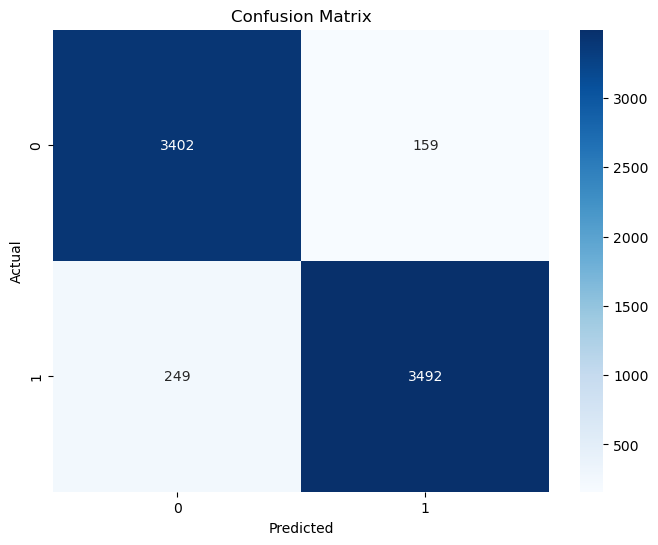

In [82]:
# Evaluate the performance of the model
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [83]:
# Print the formatted classification report
class_report = classification_report(y_test, y_pred_svm)
print("\tSVM Classification Report:\n\n", class_report)

	SVM Classification Report:

               precision    recall  f1-score   support

           0       0.93      0.96      0.94      3561
           1       0.96      0.93      0.94      3741

    accuracy                           0.94      7302
   macro avg       0.94      0.94      0.94      7302
weighted avg       0.94      0.94      0.94      7302



## <span style="color:blue">4. Logistic Rregression</span>

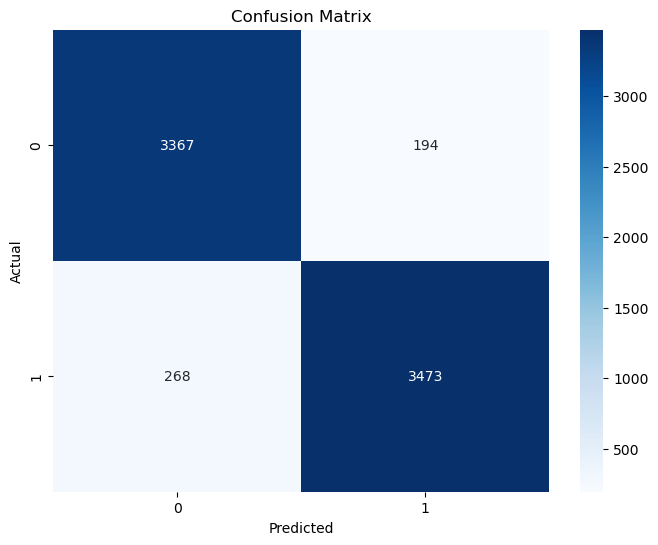

In [84]:
# Evaluate the performance of the model
conf_matrix = confusion_matrix(y_test, y_pred_l)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [85]:
# Print the formatted classification report
class_report = classification_report(y_test, y_pred_l)
print("\tLogistic Rregression Classification Report:\n\n", class_report)

	Logistic Rregression Classification Report:

               precision    recall  f1-score   support

           0       0.93      0.95      0.94      3561
           1       0.95      0.93      0.94      3741

    accuracy                           0.94      7302
   macro avg       0.94      0.94      0.94      7302
weighted avg       0.94      0.94      0.94      7302



## <span style="color:blue">5. Choose the best model</span>

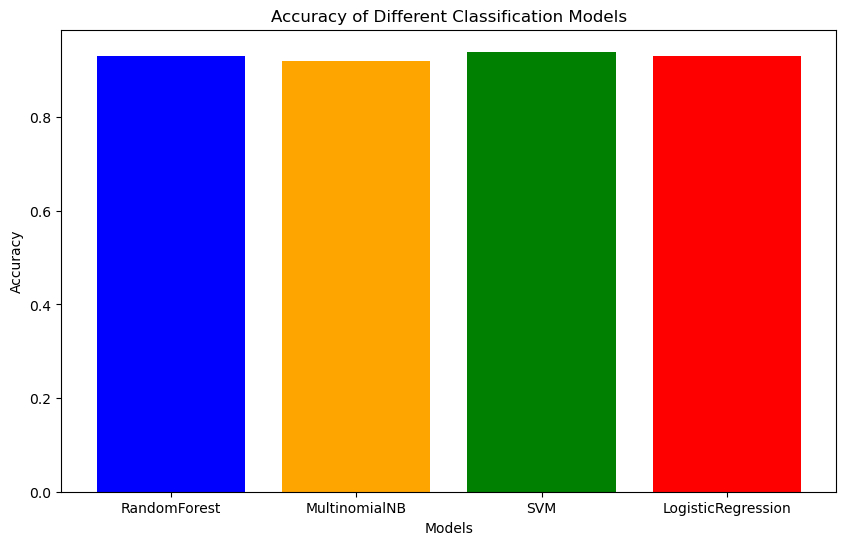

In [86]:
# Model names
models = ['RandomForest', 'MultinomialNB', 'SVM', 'LogisticRegression']

# Accuracy scores for each model
accuracies = [0.93, 0.92, 0.94, 0.93]  

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])

# Add title and labels
plt.title('Accuracy of Different Classification Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Show plot
plt.show()

Based on the provided accuracy scores:

- RandomForest: 0.93
- MultinomialNB: 0.92
- SVM: 0.94
- LogisticRegression: 0.93

The SVM model has the highest accuracy (0.94), closely followed by RandomForest and LogisticRegression (both with an accuracy of 0.93). MultinomialNB has the lowest accuracy (0.92). Therefore, the best model is SVM.


# <span style="color:orange">VII. Inference</span>
After satisfactory evaluation results, the model can be used to make predictions, called inferences, on unlabeled examples.

In [87]:
def extract_features(cleaned_text):
    # Apply feature extraction functions
    count_pos_words = count_positive_words(cleaned_text)
    count_neg_words = count_negative_words(cleaned_text)
    contain_no_val = contain_no(cleaned_text)
    contain_not_val = contain_not(cleaned_text)
    contain_exclamation_val = contain_exclamation(cleaned_text)
    log_length = log_review_length(cleaned_text)
    emotion_label = get_emotion_label(cleaned_text)
    sentiment_score = calculate_sentiment_score(cleaned_text)
    return [count_pos_words, count_neg_words, contain_no_val, contain_not_val, contain_exclamation_val, log_length, emotion_label, sentiment_score]

def predict_sentiment(features):
    # Transform features into DataFrame
    df = pd.DataFrame([features], columns=numerical_columns)
    # Scale the numerical features
    df[numerical_columns] = scaler.transform(df[numerical_columns])
    # Apply TF-IDF transformation
    tfidf_text = tfidf_vectorizer.transform([cleaned_text])
    # Concatenate TF-IDF features with numerical features
    X = hstack([tfidf_text, csr_matrix(df[numerical_columns].values)])
    # Predict sentiment using the SVM model
    prediction = svm_classifier.predict(X)
    # Map prediction to sentiment label
    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment

# Input text
input_text = "This product exceeded my expectations!"

# Preprocess the input text
cleaned_text = text_preprocessing(input_text)

# Extract features from the cleaned text
features = extract_features(cleaned_text)

# Predict sentiment based on the extracted features
predicted_sentiment = predict_sentiment(features)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: Positive


In [89]:
# Input text
input_text = "I was really disappointed with the product. It didn't work as advertised and broke after just a few days of use."

# Preprocess the input text
cleaned_text = text_preprocessing(input_text)

# Extract features from the cleaned text
features = extract_features(cleaned_text)

# Predict sentiment based on the extracted features
predicted_sentiment = predict_sentiment(features)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: Negative


# <span style="color:orange">VIII. Model Saving</span>

In [90]:
joblib.dump(svm_classifier, 'best_model.pkl')

['best_model.pkl']

In [91]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [92]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']